Below, [section 3.1](https://gmd.copernicus.org/articles/14/5269/2021/#Ch1.S3.SS1) from Mengel et al. (2021)

Mengel, M., Treu, S., Lange, S., and Frieler, K.: ATTRICI v1.1 – counterfactual climate for impact attribution, Geosci. Model Dev., 14, 5269–5284, <https://doi.org/10.5194/gmd-14-5269-2021>, 2021. 

In [1]:
import numpy as np
import xarray as xr

> ## 3.1 Detrending method
>
> A very basic detrending approach would fit a linear temporal trend for
all data of each day of the year assuming normally distributed residuals
and remove the estimated trends from the data for each day of the year
separately. In this approach the trend estimates would not only vary
according to systematic variations in trends from one day of the year to
the other but also randomly fluctuate from one day of the year to the
next one in terms of the uncertainties associated with the individual
estimates. We go beyond this very basic approach by (i) using global
mean temperature change instead of time as a potentially powerful
predictor of regional changes in climate, (ii) allowing for non-normal
distributions of the unexplained random year-to-year fluctuations of
data per day of the year, and (iii) ensuring a smooth variation of
estimated model parameters from one day of the year to the other.
>
> The use of GMT change, $T$, as the predictor of regional climate change
is motivated by the classical pattern scaling approach (Santer et al.,
1990; Mitchell, 2003), with newer approaches including additional
predictors such as a distinction between land and sea to improve
accuracy (Herger et al., 2015). Here, $T$ is GMT change since 1901
smoothed by singular spectrum analysis (SSA, Ghil et al., 2002) with a
smoothing window of 10 years (Fig. 3). The smoothing of the predictor is
applied because we only want to remove long-term trends from the
regional climate time series. Natural climate variability on shorter
timescales due to phenomena such as the El Niño--Southern Oscillation is
retained.

> **Figure 3 from Mengel et al. (2021)**
<figure id="Ch1.F3">
<p><img width="300"
src="https://gmd.copernicus.org/articles/14/5269/2021/gmd-14-5269-2021-f03.png" /></p>
<figcaption><small>Time series of GMT change since 1901 derived from GSWP3-W5E5
near-surface air temperature data. Shown are annual mean GMT change
(gray) and GMT change smoothed by SSA with a smoothing window of 10
years (pink). The smoothed GMT change is used as the predictor of
regional climate change in our detrending model (denoted by <span
class="math inline"><em>T</em></span> in the text).</small></figcaption>
</figure>

> Using $T$ as the predictor means that we remove long-term trends in
regional climate to the extent that those are correlated with GMT
change, but irrespective of the cause of global warming. The success of
the detrending is evaluated by a number of control measures described in
Sect. 3.3.
>

In the ATTRICI package SSA is implemented as a vendored SSA algorithm (`attrici.vendored.singularspectrumanalysis`) in the `attrici.preprocessing` module.

It also can be called from the command line as `attrici ssa`.

Example data for testing is included in the library, as shown below.

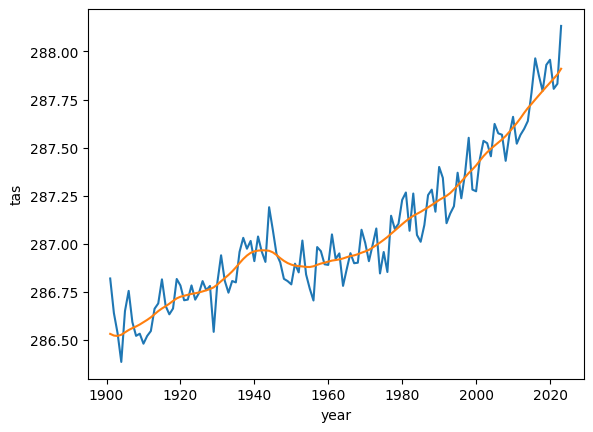

In [2]:
raw_gmt = xr.load_dataset("../tests/data/20crv3-era5_gmt_raw.nc").tas
ssa_gmt = xr.load_dataset("../tests/data/20CRv3-ERA5_germany_ssa_gmt.nc").tas

raw_gmt.groupby("time.year").mean().plot()
ssa_gmt.groupby("time.year").mean().plot();

 
> For each day of the year $t$ the detrending is done with quantile
mapping (Wood et al., 2004; Cannon et al., 2015; Lange, 2019) from the
factual distribution $A\left( {T,t} \right)$ to the counterfactual
distribution $A\left( {T = 0,t} \right)$. The dependence of $A$ on $T$
is modeled via the expected value $\mathit{\mu}$ of the distribution,
using a generalized linear model (GLM) or beta regression (Ferrari and
Cribari-Neto, 2004) with a link function $g$ defined by
$g\left( {\mathit{\mu}\left( {T,t} \right)} \right) = c_{0}(t) + c_{1}(t)T$.
The link function $g$ is used to account for climate variables that can
only be positive (in that case, $\left. g(x) = {ln⁡}(x) \right)$ or can
only take values between 0 and 1 (in that case,
$\left. g(x) = {ln⁡}\left( {x/\left( {1 - x} \right)} \right) \right)$.
In all other cases $g(x) = x$. See Table 1 for an overview of which
distributions and link functions are used for the different climate
variables, and see Sect. 3.2 for further details. For variables modeled
by a Gaussian distribution, the variance $\mathit{\sigma}^{2}$ of $A$ is
assumed to stay constant for each day of the year; i.e.,
$\mathit{\sigma}^{2}$ does not vary with $T$ but only depends on $t$.
For non-Gaussian distributions, the variance is assumed to change with
the expected value. In that case we assume the shape of the distribution
to stay constant for each day of the year.

The statistical model for each variable is described in the `create_model` method of the dedicated subclass, e.g. `Tas` for near-surface temperature, of the `Variable` class in `attrici.variables`.

In [3]:
# Simplified example from `attrici.variables.Tas`
from attrici import distributions
from attrici.estimation.model import AttriciGLM


def identity(x):
    return x


def create_model(y_scaled, statistical_model_class, predictor):
    observation = y_scaled.sel(time=y_scaled.notnull()).sel(time=predictor.time)
    return statistical_model_class(
        distribution=distributions.Normal,
        parameters={
            "mu": AttriciGLM.Parameter(link=identity, dependent=True),
            "sigma": AttriciGLM.Parameter(link=np.exp, dependent=False),
        },
        observed=observation,
        predictor=predictor.sel(time=observation.time),
        modes=4,
    )

Here, for the parameters $\mu$ and $\sigma$ the respective GLM is described by `attrici.estimation.model.AttriciGLM.Parameter` with link functions $g(x) = x$ (`identity`) and $g(x) = e^x$ (`np.exp`), respectively. Also, $\mu$ varies with $T$ (`dependent=True`), whereas $\sigma$ does not (`dependent=False`). 

The statistical models are defined in the `attrici.variables` module.

**[Table 1 from Mengel et al. (2021)](https://gmd.copernicus.org/articles/14/5269/2021/gmd-14-5269-2021-t01.png)**

<small>Climate variables covered by ISIMIP3a counterfactual climate datasets.
Listed are each variable\'s short name and unit as well as the
statistical distribution and link function used for detrending it. Also
specified is the dependence of the distribution parameters on GMT
change, $T$, and day of the year, $t$, as used in our GLM. The variables
tasrange and tasskew are auxiliary variables used to detrend tasmin and
tasmax.</small>

<img src="https://gmd.copernicus.org/articles/14/5269/2021/gmd-14-5269-2021-t01-thumb.png" target="_blank" data-webversion="https://gmd.copernicus.org/articles/14/5269/2021/gmd-14-5269-2021-t01-web.png" data-width="2067" data-height="1967" data-printversion="https://gmd.copernicus.org/articles/14/5269/2021/gmd-14-5269-2021-t01.png" data-csvversion="https://gmd.copernicus.org/articles/14/5269/2021/gmd-14-5269-2021-t01.xlsx">


> We use harmonics for the representation of the annual cycle, i.e., the
dependence of the coefficients $c_{0}(t)$ and $c_{1}(t)$ on the day of
the year $t$. Specifically, we use $$\begin{matrix}
 & {g\left( {\mathit{\mu}\left( {T,t} \right)} \right) = a_{0}(T) + \sum_{k = 1}^{n}a_{k}(T){cos⁡}\left( {k\mathit{\omega}t} \right)} \\
 & {\quad + b_{k}(T){sin⁡}\left( {k\mathit{\omega}t} \right)}
\end{matrix}$$ to model the dependence of $\mathit{\mu}$ on $T$ and $t$.
Here, $\mathit{\omega} = \frac{2\mathit{\pi}}{365.25}$ and $n = 4$
Fourier modes are used to model the annual cycle. The GMT-change
dependence of the Fourier coefficients $a_{k},b_{k}$ is modeled
linearly,
$$a_{k}(T) = a_{k}^{(\text{slope})}T + a_{k}^{(\text{intercept})};k = 0,1,\ldots,n,$$
and similarly for $b_{1},b_{2},\ldots,b_{n}$.

Harmonics are calculated in `attrici.util.calc_oscillations`. Note that an alternative rolling-window based approach has been included in ATTRICI as well. These options are set with `window_size` or `modes` in the main `attrici.detrend.detrend` function.

The actual solving of the statistical model is done by a solver, of which currently, `PyMC3`, `PyMC5`, and a `SciPy` variant are implemented. For instance, for the `PyMC5` solver (in `attrici.estimation.model_pymc5`), the `AttriciGLMPymc5.PredictorDependentParam` solves a $T$-dependent statistical model, see below:

In [4]:
def build_linear_model(self, oscillations, predictor):
    """
    Build a linear model for predictor-dependent parameters.

    Parameters
    ----------
    oscillations : pytensor.Tensor
        The oscillation data for the model.
    predictor : pytensor.Tensor
        The predictor data.

    Returns
    -------
    pytensor.Tensor
        The linear model for the parameter.
    """
    weights_longterm_intercept = pm.Normal(
        f"weights_{self.name}_longterm_intercept",
        mu=AttriciGLMPymc5.PRIOR_INTERCEPT_MU,
        sigma=AttriciGLMPymc5.PRIOR_INTERCEPT_SIGMA,
    )
    weights_fc_intercept = pm.math.concatenate(
        [
            pm.Normal(
                f"weights_{self.name}_fc_intercept_{i}",
                mu=AttriciGLMPymc5.PRIOR_INTERCEPT_MU,
                sigma=1 / (2 * i + 1),
                shape=2,
            )
            for i in range(self.modes)
        ]
    )

    covariates = pm.math.concatenate(
        [
            oscillations,
            pt.tile(predictor[:, None], (1, 2 * self.modes)) * oscillations,
        ],
        axis=1,
    )
    weights_longterm_trend = pm.Normal(
        f"weights_{self.name}_longterm_trend",
        mu=AttriciGLMPymc5.PRIOR_TREND_MU,
        sigma=AttriciGLMPymc5.PRIOR_TREND_SIGMA,
    )
    weights_fc_trend = pm.Normal(
        f"weights_{self.name}_fc_trend",
        mu=AttriciGLMPymc5.PRIOR_TREND_MU,
        sigma=AttriciGLMPymc5.PRIOR_TREND_SIGMA,
        shape=2 * self.modes,
    )
    weights_fc = pm.math.concatenate([weights_fc_intercept, weights_fc_trend])
    return (
        pt.dot(covariates, weights_fc)
        + weights_longterm_intercept
        + weights_longterm_trend * predictor
    )


def estimate(self, trace, predictor):
    """
    Estimate the parameter based on a trace.

    Parameters
    ----------
    trace : dict
        The trace to estimate from.
    predictor : xarray.DataArray
        The predictor data.

    Returns
    -------
    numpy.ndarray
        The estimated parameter value.
    """
    oscillations = calc_oscillations(predictor.time, self.modes)
    weights_longterm_intercept = trace[f"weights_{self.name}_longterm_intercept"]
    weights_fc_intercept = np.concatenate(
        [trace[f"weights_{self.name}_fc_intercept_{i}"] for i in range(self.modes)],
    )
    covariates = np.concatenate(
        [
            oscillations,
            np.tile(predictor.values[:, None], (1, 2 * self.modes)) * oscillations,
        ],
        axis=1,
    )
    weights_longterm_trend = trace[f"weights_{self.name}_longterm_trend"]
    weights_fc_trend = trace[f"weights_{self.name}_fc_trend"]
    weights_fc = np.concatenate([weights_fc_intercept, weights_fc_trend])
    return self.link(
        np.dot(covariates, weights_fc)
        + weights_longterm_intercept
        + weights_longterm_trend * predictor.values
    )

> The distribution parameters that only depend on $t$ are modeled using
$$\begin{matrix}
 & {{ln⁡}\left( {\mathit{\nu}(t)} \right) = a_{0}^{(\text{constant})} + \sum_{k = 1}^{n}a_{k}^{(\text{constant})}{cos⁡}\left( {k\mathit{\omega}t} \right)} \\
 & {\quad + b_{k}^{(\text{constant})}{sin⁡}\left( {k\mathit{\omega}t} \right),}
\end{matrix}$$ where $\mathit{\omega}$ and $n$ have the same values as
in Eq. (1), and $\mathit{\nu}$ represents $\mathit{\sigma}$ for the
Gaussian distribution, $k$ for the gamma distribution, $\mathit{\alpha}$
for the Weibull distribution and $\mathit{\phi}$ for the beta
distribution (see Table 1 and Sect. 3.2).

Similarly, for the `AttriciGLMPymc5.PredictorIndependentParam`:

In [5]:
def build_linear_model(self, oscillations):
    """
    Setup a linear model for predictor-independent parameters.

    Parameters
    ----------
    oscillations : pytensor.Tensor
        The oscillation data for the model.

    Returns
    -------
    pytensor.Tensor
        The linear model for the parameter.
    """
    weights_longterm_intercept = pm.Normal(
        f"weights_{self.name}_longterm_intercept",
        mu=AttriciGLMPymc5.PRIOR_INTERCEPT_MU,
        sigma=AttriciGLMPymc5.PRIOR_INTERCEPT_SIGMA,
    )
    weights_fc_intercept = pm.math.concatenate(
        [
            pm.Normal(
                f"weights_{self.name}_fc_intercept_{i}",
                mu=0,
                sigma=1 / (2 * i + 1),
                shape=2,
            )
            for i in range(self.modes)
        ]
    )
    return pt.dot(oscillations, weights_fc_intercept) + weights_longterm_intercept


def estimate(self, trace, predictor):
    """
    Estimate the parameter based on a trace.

    Parameters
    ----------
    trace : dict
        The trace to estimate from.
    predictor : xarray.DataArray
        The predictor data.

    Returns
    -------
    numpy.ndarray
        The estimated parameter value.
    """
    oscillations = calc_oscillations(predictor.time, self.modes)
    weights_longterm_intercept = trace[f"weights_{self.name}_longterm_intercept"]
    weights_fc_intercept = np.concatenate(
        [trace[f"weights_{self.name}_fc_intercept_{i}"] for i in range(self.modes)],
    )
    return self.link(
        np.dot(oscillations, weights_fc_intercept) + weights_longterm_intercept
    )

> By limiting the number of Fourier modes to four we reduce the number of
coefficients to be estimated and ensure a smooth variation of the
long-term trend in $\mathit{\mu}$ over the course of the year but still
capture seasonal to sub-seasonal patterns such as monsoon season onsets.
Setting $n = 4$ in Eq. (1) leads to a total of 18 slope and intercept
parameters to describe the expected value $\mathit{\mu}$ in terms of $T$
and $t$. Setting $n = 4$ in Eq. (3) means that nine parameters are used
to describe the dependence of $\mathit{\sigma}$, $k$, $\mathit{\alpha}$
and $\mathit{\phi}$ on $t$.

In ATTRICI `n = 4` is used as the default for the `modes` config variable.

> We use a Bayesian approach to estimate all of these parameters. This
requires the specification of prior distributions of the model
parameters. Similar to regularization techniques in frequentist
approaches, the prior allows us to focus the model fitting on plausible
parameter values. This is particularly important for numeric stability
when the logit and logarithm link functions are applied. We use a
zero-centered Gaussian prior for all parameters and all climate
variables because we normalize the data before parameter estimation. We
use a standard deviation of 1.0 for $a_{0}^{(\text{intercept})}$; a
standard deviation of $1/\left( {2k - 1} \right)$ for
$a_{k}^{(\text{intercept})}$, $k = 1,\ldots,4$; and a standard deviation
of 0.1 for $a_{k}^{(\text{slope})}$, $k = 0,\ldots,4$. Our choice of
priors for $a_{k}^{({intercept})}$ is based on the assumption that the
first mode with a period of 1 year explains the largest part of the
annual cycle and higher-order modes have decreasing influence. However
this is only a prior assumption; i.e., if the data show different
patterns, they can still be captured by our model. For
$a_{k}^{(\text{constant})}$ we use the same priors as for
$a_{k}^{(\text{intercept})}$. We use the same priors for the parameters
$b_{k}$. We technically implemented the model fitting by use of the
pymc3 python package (Salvatier et al., 2016). Before the regression,
all time series are normalized to simplify the Bayesian model parameter
estimation. To restore the original units, the normalization is reversed
after detrending.

The priors can be seen in the `build_linear_model` methods above. As an example for the statistical model let's prepare input data first:

In [6]:
# Example data for one grid cell in Germany
obs_data = xr.load_dataset("../tests/data/20CRv3-ERA5_germany_obs.nc").tas.sel(
    lon=9.25, lat=51.25
)

# First, we interpolate and scale the predictor, GMT:
t_scaled = (obs_data.time - obs_data.time.min()) / (
    obs_data.time.max() - obs_data.time.min()
)

gmt_on_obs_times = np.interp(t_scaled, np.linspace(0, 1, len(ssa_gmt)), ssa_gmt)
gmt_scaled_values = (gmt_on_obs_times - gmt_on_obs_times.min()) / (
    gmt_on_obs_times.max() - gmt_on_obs_times.min()
)
gmt_scaled = xr.DataArray(
    gmt_scaled_values, coords={"time": obs_data.time}, dims=("time",)
)

# And scale the observation data
datamin = obs_data.min()
scale = obs_data.max() - datamin
y_scaled = (obs_data - datamin) / scale

In [7]:
obs_data

<xarray.DataArray 'tas' (time: 44925)> Size: 180kB
array([265.12433, 263.13016, 263.1708 , ..., 281.453  , 279.96188,
       279.81735], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 359kB 1901-01-01 1901-01-02 ... 2023-12-31
    lon      float64 8B 9.25
    lat      float64 8B 51.25
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K

In [8]:
from attrici.estimation.model_pymc5 import ModelPymc5

statistical_model_class = ModelPymc5
predictor = gmt_scaled
model = create_model(y_scaled, statistical_model_class, predictor)
# Internal PyMC representation
model._model

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
2025-07-29 13:46:56.508 | INFO     | attrici.estimation.model_pymc5:__init__:578 - Using PyMC5 version 5.19.0


> The overall intention of our approach is to find appropriate parameter
values such that $A\left( {T,t} \right)$ captures long-term trends in
the variables that can be removed by setting $T$ to zero. This is
important because the counterfactual distributions are then defined by
$A\left( {T = 0,t} \right)$. As an example, the factual
$\mathit{\mu}\left( {T,t} \right)$ and the counterfactual
$\mathit{\mu}\left( {T = 0,t} \right)$ as well as the associated daily
values of one particular tas time series are shown in Fig. 4. The
difference between the expected values of distribution
$A\left( {T, \cdot} \right)$ (black line) and
$A\left( {T = 0, \cdot} \right)$ (orange line) is due to a vertical
shift that is composed of a linear increase with $T$ captured by $a_{0}$
and a change in the amplitude and phase of the annual cycle captured by
the Fourier coefficients $a_{k}$ and $b_{k}$, $k > 0$. The
counterfactual daily data are generated by quantile mapping; i.e., an
observed value $x$ that corresponds to a certain quantile of the factual
distribution $A\left( {T,t} \right)$ is mapped to the counterfactual
value $x^{\prime}$ that corresponds to the same quantile of the
counterfactual distribution $A\left( {T = 0,t} \right)$. We illustrate
this for an observed value $x$ that corresponds to the 95th percentile
of the factual distribution in Fig. 4: we first obtain the cumulative
probability of the factual (i.e., observed) temperature (large black dot
in panel a) from the factual cumulative distribution function (CDF;
black line in panel b). We then obtain the counterfactual temperature
(large orange dot in panel a) from the counterfactual CDF (orange line
in panel b).

Quantile mapping is done using the `quantile_mapping` method in the `attrici.variables.Variable` class (can be overwritten for specific variables, e.g. `Pr`). In general:

In [9]:
def quantile_mapping(self, distribution_ref, distribution_cfact):
    """
    Map data to respective quantile in the reference distribution.

    Parameters
    ----------
    distribution_ref : Distribution
        The reference distribution.
    distribution_cfact : Distribution
        The counterfactual distribution.

    Returns
    -------
    xarray.DataArray
        Data mapped to the respective quantile in the reference distribution.
    """
    return distribution_cfact.invcdf(distribution_ref.cdf(self.y_scaled))

The distributions including their cumulative distribution function (`cdf`) and its inverse (`invcdf`) are given in the `attrici.distributions` module.

**Figure 4 from Mengel et al. (2021)**
<figure id="Ch1.F4">
<p><img width="500"
src="https://gmd.copernicus.org/articles/14/5269/2021/gmd-14-5269-2021-f04.png" /></p>
<figcaption><small>Illustration of detrending with quantile mapping sensitive
to the annual cycle. Panel <strong>(a)</strong> shows the factual (black
points) and counterfactual (orange points) daily mean near-surface air
temperature data for the year 2016 of GSWP3-W5E5 for a single grid cell
in the Mediterranean region at 43.25<span
class="math inline"><sup>∘</sup></span> N, 5.25<span
class="math inline"><sup>∘</sup></span> E. In panel
<strong>(a)</strong>, the black and orange lines show the temporal
evolution of the expected value <span
class="math inline"><em>μ</em></span> of the factual and the
counterfactual distribution. In panel <strong>(b)</strong>, the black
and orange lines show the factual and counterfactual cumulative
distribution function (CDF) for a single day (25 October 2016). The
large points on the dashed vertical line in panel <strong>(a)</strong>
highlight the factual (large black point) and counterfactual (large
orange point) value on 25 October. They correspond to the 95th
percentile in their respective distributions.</small></figcaption>
</figure>